In [2]:
from IPython.html.services.config import ConfigManager
from IPython.paths import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

{u'scroll': True,
 u'start_slideshow_at': 'selected',
 u'theme': 'sky',
 u'transition': 'zoom'}

In [1]:
#import
import tt
import numpy as np
import scipy.linalg as la
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import math

#Graphics
import matplotlib.pyplot as plt
#import prettyplotlib as ppl
%matplotlib inline

# Tensor decompositions: new results and open problems
##### Ivan Oseledets
##### Skolkovo Institute of Science and Technology
##### Based on joint work with M. Rakhuba, V. Kazeev, C. Schwab, A. Chertkov, D. Kolesnikov




## Tensor decompositions

The idea of tensor decompositions is based on the idea of **separation of variables**.

**Rank-$1$ tensor**: $$A(i_1, \ldots, i_d) \approx U_1(i_1) \ldots U_d(i_d),$$

**Canonical rank-$r$ tensor**: $$A(i_1, \ldots, i_d) \approx \sum_{\alpha=1}^r U_1(i_1, \alpha) \ldots U_d(i_d, \alpha),$$

**Tensor-train (MPS)**: $$A(i_1, \ldots, i_d) = G_1(i_1) \ldots G_d(i_d),$$ where $G_k(i_k)$ is an $r_{k-1} \times r_k$ matrix.

Tree-tensor networks (include H-Tucker, TT) are the most general **stable** representation class.

## (Well-known) properties of the tensor formats

- Canonical format is in general an unstable representation; the set of tensors with bounded canonical rank does not form a manifold
- SVD-based format with fixed ranks form a **Riemannian manifold**, and come with a bunch of stable algorithms

## Tensor-train format properties:

- Fast linear algebra
- Generalization of the SVD (TT-SVD, Vidal algorithm)
- Rounding proceduring in $\mathcal{O}(dnr^3)$ complexity
- Exact recovery from samples of low-rank tensors (**cross approximation**)
- Software available for MATLAB & Python for testing and development purposes.

## Challenges


There are several challenges in tensor decompositions:

0. Make it work for the particular problem: right parametrization/reshaping into a tensor (i.e. similar
1. Develop **black-box** optimization over low-rank manifolds, when you know that the solution is in the right format
2. Investigate theoretical convergence properties: the current analysis is insufficient for the convergence of ALS-type methods.

## New result: tensors for the multiscale problems

One of the most interesting applications of the tensor methods is the **direct resolution** in multiscale problems with very fine meshes.

[Nice picture]

## Model problem

As a model problem, consider a diffusion problem with a highly oscillating coefficient

$$\nabla \cdot k \nabla u = f, $$

in $[0, 1], u_{\partial \Omega} = 0.$ 

for simplicity, let us focus on the 1D case, and suppose **two-scale** problem:

$$k = K_1(x) K_2\left(\frac{x}{\epsilon}\right),$$

where $K_2(y)$ is a 1-periodic function, $K_1(x)$ is smooth, $\epsilon \ll 1$.

## The scheme: 

The **ideal** tensor scheme:

Introduce a very fine mesh with $n = 2^d$ points, use the simplest low-order **finite-element method**

take a vector of value of 

## QTT: core idea and results

## The theory 

The theory in our recent paper Kazeev, Schwab, Rakbuba, Oseledets shows that the solution can be approximated in with QTT-FEM format with **optimal complexity**.


## The solver

We put the matrix into the QTT-format, the right-hand side into the QTT-format, 

and have a linear system 

$$Ax = f$$ where we know that the solution can be well-approximated in the QTT-format.

A **standard way** is to reformulate the problem as a minimization problem of the functional $F(x)$

$$F(x) = <Ax, x> - 2<f, x>,$$

and minimize over the set of all tensors with bounded ranks. There is a very nice black-box software for doing that (ALS, DMRG, AMEN method by Dolgov & Savostyanov).

## Practice:

Does not work even for $k = 1$!

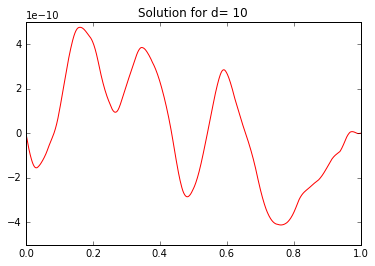

In [25]:
import numpy as np
import tt
from tt.amen import amen_solve
import matplotlib.pyplot as plt
%matplotlib inline


d = 10
n = 2 ** d b
a = tt.qlaplace_dd([d]) * (n + 1) ** 2
rhs = tt.ones(2, d)

sol = amen_solve(a, rhs, rhs, 1e-6, verb=1)
#print (tt.matvec(a, sol) - rhs).norm()/rhs.norm()
t = np.linspace(0, 1, n+2)[1:-1]
sol_analyt = 0.5 * t * (1 - t)
#plt.plot(t, sol.full().flatten("F"))
plt.plot(t, sol_analyt - sol.full().flatten("F"), 'r')
plt.title('Solution for d={0: d}'.format(d))


## What is the source of the problem:

We have the **discretization error** and the **floating point** error:

$$\frac{C\epsilon}{h^2} + h^2 $$

and this is the minimum for

$$h \sim \epsilon^{1/4} \approx 10^{-4}$$

for $\epsilon = 10^{-16}$ (btw. this is why you never use single precision in FEM).

Standard FEM can not allow to go beyond $h = 10^{-4}$, but we need in tensor methods to go to **astronomically large** sizes $n$.

## Discretization for astronomically large $n$.


We have come up with a ``simple'' scheme that solves the problem.

In 1D, we have new variable:

$$\frac{d}{dx} k \frac{d}{dx} u = f, $$

we introduce 

$$u_x = \frac{du}{dx}, \quad u = \int^x_0 u_x(t) dt.$$ 

and replace this by  a discretization

$$u = B u_x, $$

where $B$ is a lower triangular Toeplitz matrix with all elements equal to $h$.

$$k u_x = B f + \alpha, \quad e^{\top} u_x = 0.$$



## 2D: the idea

In two dimensions, we introduce in a similar way unknowns $u_x$, $u_y$, 

which are connected:

$$u = (B \otimes I) u_x, \quad u = (I \otimes B) u_y, \quad \mbox{+ b.c.}.$$

## Final equation 

The final equation for $\nabla \cdot k \nabla$ has the form
$$
    \begin{split}
        &M_x D^{-1}_x M_x^{\top} \mu + M_y D^{-1}_y M_y^{\top} \mu -  M_x D^{-1}_x S^{\top}_x Q^{-1}_x S_x D_x^{-1} M_x^{\top} \mu  \\ &- M_y D^{-1}_y S^{\top}_y Q^{-1}_y S_y D^{-1}_y M_y^{\top} \mu = M_x D^{-1}_x M_x^{\top} f
        - M_x D^{-1}_x S^{\top}_x Q^{-1}_x S_x D_x^{-  1} M_x^{\top} f,
\end{split}
$$
where $D_x$, $D_y$, $Q_x$, $Q_y$ are auxiliary diagonal matrices, 

and that is the system solved by **AMEN method**.

## Typical convergence

The QTT-ranks stay constant, solution time is of order of ten seconds ($d = 30$ total number of virtual unknowns $2^{60}$.)

<img src='simple_ref.png' /img>

## Summary 

Special discretization are needed for QTT-tools to be efficient in the PDE setting.

Theory is available for 2D elliptic PDEs in polygonal domain (Kazeev & Schwab) and for 1D multiscale (O., Rakhuba, Kazeev, Schwab).

Multiscale experiments also done in the paper by Khoromskij & Repin

## High-dimensional eigenvalue problem

In vibrational computations, it is needed to find the minimal eigenvalues of the molecular Schrodinger operator,

$$H \Psi_k = E_k \Psi_k, \quad H = \frac{1}{2} \Delta + V,$$

where potential is already given in the sum-of-product form (typically, polynomial expansion).

Discretization on a tensor-product grid yield an $N$-dimensional tensor, where $N$ is the number of molecular degrees of freedom.

## New approach

Run Locally Optimal Block Conjugate Method (LOBPCG)  by Knyazev with iterates stored separatedly in the TT-format.

Need: 

- Block Matvec: fast approximate available in the TT-Toolbox
- Orthogonalization: done via Gram matrix, can be done **inexactly**.

Key idea: 

**Fine-tune with inexact inverse iteration**
 


## Fine-tuning with inexact inverse iteration

Given a guess $\lambda_i$ to the eigenvalue we solve

$$(A - \lambda_i I) x_i^{(k+1)} = x^{(k)}_i$$

by running one sweep of ALS.

It is very cheap, but it works extremely well.

## Key  idea explained again

Typically, in the AMEN approach the gradient direction is used to enhance the optimization method;

In the new approach, we use **ALS** to precondition the outer tensor-structured iteration.

## Results
  <img src='comparison_smolyak.png' /img>

## Results (2)

<img src='lobpcg.png' /img>

## Open problems

One of the most interesting open problem is the convergence analysis of the optimization algorithm on the manifold of low-rank matrices and tensors.

Even for matrices it is not yet understood, and requires experts from topology and differential geometry.

## Optimization problems examples

- Linear systems: $F(X) = \langle A(X), X \rangle - 2 \langle F, X\rangle.$
- Eigenvalue problems $F(X) = \langle A(X), X \rangle, \mbox{s.t.} \Vert X \Vert = 1.$
- Tensor completion: $F(X) = \Vert W \circ (A  - X)\Vert.$

My claim is that we need better understanding of how these methods converge!

## General scheme
The general scheme is that we have some (convergent method) in a full space:

$$X_{k+1} = \Phi(X_k),$$

and we know that the solution $X_*$ is on the manifold $\mathcal{M}$.

Then we introduce a **Riemannian projected method**

$$X_{k+1} = R(X_k + P_{\mathcal{T}} \Phi(X_k)),$$

where $P_{\mathcal{T}}$ is a projection on the **tangent space**, and $R$ is a **retraction**.

## Riemannian optimization is easy

The projection onto the tangent space is trivial for low-rank (and is not difficult for TT)

$$P_{T}(X) = X - (I - UU^{\top}) X (I - VV^{\top}).$$

For the retraction, there **many choices** (see the review Absil, O., 2014).

## Projector-splitting scheme 
One of the simplest **second-order retractions** is the projector-splitting (or KSL) scheme 

Initially proposed as a time integrator for the dynamical low-rank approximation (C. Lubich, I. Oseledets, **A projector-splitting...** 2014) for matrices and (C. Lubich, I. Oseledets, B. Vandreycken, 
**Time integration of tensor trains**, SINUM, 2015).

Reformulated as a retraction in (Absil, Oseledets)

Has a trivial form: a half-step (or full) step of the Alternating least squares (ALS).

## The simplest retraction possible:
The projector-splitting scheme can be implemented in a very simple "half-ALS" step.

$$ U_1, S_1 = \mathrm{QR}(A V_0),  \quad V_1, S_2^{\top} = \mathrm{QR}(A^{\top} U_1).$$

## Projection onto the tangent space not needed!

$$X_{k+1} = I(X_k, F), $$

where $I$ the is the **projector-splitting** integrator, and $F$ is the step for the full method.

## What about the convergence?

Now, instead of $$X_{k+1} = \Phi(X_k), \quad X_* = \Phi(X_*),$$

and $X_*$ is on the manifold, we have the **manifold-projected** process

$$Y_{k+1} = I(Y_k, \Phi(Y_k) - Y_k).$$

## Linear manifold
Suppose the linear case,
$$\Phi(X) = X + Q(X), \quad \Vert Q \Vert < 1.$$

and $M$ is a **linear subspace**. Then the projected method is always **not slower.**

On a curved manifold, the **curvature** of the manifold plays crucial role in the convergence estimates.

## Curvature of fixed-rank manifold

The curvature of the manifold of matrices with rank $r$ at point $X$ is equal to the $$\Vert X^{-1} \Vert_2,$$

i.e. the inverse of the minimal singular value.


**In practice we know,** that zero singular values for the **best rank-r** approximation **do not harm:**


Approximation of a rank-$1$ matrix with a rank-$2$ matrix is ok (block power method.)


## Experimental convergence study

Our numerical experiments confirm that the low-rank matrix manifold behaves typically like a **linear manifold**, i. e. 

**projected gradient** is almost always faster, independent of the curvature.

In [26]:
#2d case functions
def grad(A, x, x0):
    #u, s, v = x
    #u0, s0, v0 = x0
    #u_new = np.linalg.qr(np.hstack((u, u0)))[0]
    #v_new = np.linalg.qr(np.hstack((v, v0)))[0]
    #s_new = u_new.T.dot(u).dot(s).dot(v.T.dot(v_new)) - u_new.T.dot(u0).dot(s0).dot(v0.T.dot(v_new))
    return x0 - A.dot(full(x).flatten()).reshape(x0.shape)
    #return (u_new, s_new, v_new)


#it is Frobenius norm
def get_norm(x):
    u, s, v = x
    return la.norm(s)
    #return math.sqrt(np.trace((u.T.dot(u)).T.dot(v.T.dot(v))))
    
    
def check_orthogonality(u): 
    if la.norm(u.T.dot(u) - np.eye(u.shape[1])) / math.sqrt(u.shape[1]) < 1e-12:
        return True
    else:
        return False
    
    
def orthogonalize(x):
    u, s, v = x
    u_new, ru = np.linalg.qr(u)
    v_new, lv = np.linalg.qr(u)
    s_new = ru.dot(s.dot(lv))
    return (u_new, s_new, v_new)


def diagonalize_core(x):
    u, s, v = x
    ls, s_diag, rs = la.svd(s)
    return (u.dot(ls), np.diag(s_diag), v.dot(rs))
    

def func(x, x0):
    return get_norm(grad(x, x0))

    
def full(dx):
    return dx[0].dot(dx[1].dot(dx[2].T))


def projector_splitting_2d(x, dx, flag_dual=False):
    n, r = x[0].shape
    u, s, v = x[0].copy(), x[1].copy(), x[2].copy()
    if not flag_dual:
        u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
        s = s - u.T.dot(dx).dot(v)
        v, s = np.linalg.qr(v.dot(s.T) + dx.T.dot(u))
        s = s.T
    else:
        v, s = np.linalg.qr(v.dot(s.T) + dx.T.dot(u))
        s = s.T
        s = s - u.T.dot(dx).dot(v)
        u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
        
    return u, s, v


def inter_point(x, dx):
    u, s, v = x
    u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
    #dx - (I - uu') dx (I - vv') = uu' dx + dx * vv' - uu' dx vv'
    dx_tangent = u.dot(u.T.dot(dx)) + (dx.dot(v)).dot(v.T) - u.dot(u.T.dot(dx).dot(v)).dot(v.T)
    
    return u.copy(), v.copy(), dx_tangent


def minus(x1, x2):
    u1, s1, v1 = x1
    u2, s2, v2 = x2
    u_new = np.linalg.qr(np.hstack((u1, u2)))[0]
    v_new = np.linalg.qr(np.hstack((v1, v2)))[0]
    s_new = u_new.T.dot(u1).dot(s1).dot(v1.T.dot(v_new)) - u_new.T.dot(u2).dot(s2).dot(v2.T.dot(v_new))
    return u_new, s_new, v_new


def ps_proj(x, dx):
    return full(projector_splitting_2d(x, dx)) - full(x)

def rotation(u):
    return la.qr(u)[0]

## Linear test case

$$\Phi (X) = X + A(X) - f,$$

where $A$ is a linear operator on matrix space, $\Vert A - I\Vert = \delta$, 

$f$ is known right-hand side and $X_*$ is the solution of linear equation $A(X_*) = f$.

This problem is equivalent to the minimization problem of the quadratic functional $F(X) = \langle A(X) - f, X \rangle.$


## Setting up the experiment

Generate some random matrices...

In [27]:
#Init sizes
n, r, r0 = 40, 7, 7

M = n * n 
Q = np.random.randn(M, M)
Q = Q + Q.T
Q = (Q/np.linalg.norm(Q, 2)) * 0.8 # contraction coefficient
A = np.eye(M) + Q

## Generic case
In the generic case, the convergence is as follows.

The singular values of fixed point matrix are 
[ 147.80354057  140.06760243  111.44163613   87.57279904   63.16382999
   29.52707096    1.3109238 ]


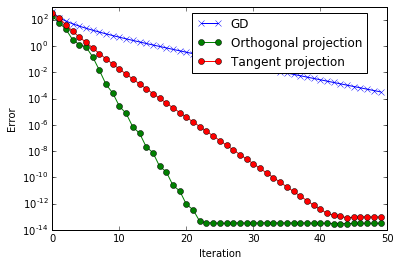

In [29]:
# Case 1: Projector-Splitting versus Gradient descent
#Random initialization
x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)
x_orig = diagonalize_core(x_orig)
print 'The singular values of fixed point matrix are \n', np.diag(x_orig[1])
f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)
grad_dist, orth_proj_norm, tangent_proj_norm = [], [], []
k = 50
# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
# Projector Splitting Convergence
x = x_start
dx_orig = full(x)-full(x_orig)
for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    dx_orig = full(x)-full(x_orig)
    dx_orig_tangent = u1.dot(u1.T.dot(dx_orig)) + (dx_orig.dot(v)).dot(v.T) - u1.dot(u1.T.dot(dx_orig).dot(v)).dot(v.T)
    orth_proj_norm.append(la.norm(dx_orig - dx_orig_tangent))
    tangent_proj_norm.append(la.norm(dx_orig_tangent))
    x = projector_splitting_2d(x, dx)
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(orth_proj_norm, marker='o', label="Orthogonal projection")
plt.semilogy(tangent_proj_norm, marker='o', label="Tangent projection")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

## Bad curvature 

Now let us design bad singular values for the solution,

$$\sigma_k = 10^{2-2k}.$$

The singular values of fixed point matrix are 
[100, 1, 0.01, 0.0001, 1e-06, 1e-08, 1e-10]


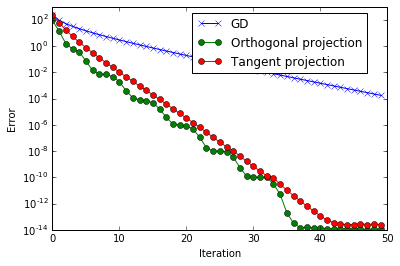

In [30]:
# Case 2: Stair convergence
x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)
x_orig = diagonalize_core(x_orig)
u, s, v = x_orig
s_diag = [10**(2-2*i) for i in xrange(r)]
x_orig = (u, np.diag(s_diag), v)
print 'The singular values of fixed point matrix are \n', s_diag
f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)
grad_dist, orth_proj_norm, tangent_proj_norm = [], [], []
k = 50
# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
# Projector Splitting Convergence
x = x_start
for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    dx_orig = full(x)-full(x_orig)
    dx_orig_tangent = u1.dot(u1.T.dot(dx_orig)) + (dx_orig.dot(v)).dot(v.T) - u1.dot(u1.T.dot(dx_orig).dot(v)).dot(v.T)
    orth_proj_norm.append(la.norm(dx_orig - dx_orig_tangent))
    tangent_proj_norm.append(la.norm(dx_orig_tangent))
    x = projector_splitting_2d(x, dx)
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(orth_proj_norm, marker='o', label="Orthogonal projection")
plt.semilogy(tangent_proj_norm, marker='o', label="Tangent projection")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

## Consequences

The typical convergence: 

- Tangent component convergence linearly.
- Normal components decays quadratically until it hits **the next singular values**, and then waits for the tangent component to catch. 
- The convergence is **monotone:** First the first singular vector converge, then the second and so on.

Adversal examples are still possible (similar to the convergence of the power method).


## Case when Riemannian is worse
You can make up an example, when on the first iteration it is worse: it is basically the **angle** between $V_*$ and $V_0$.

The singular values of fixed point matrix are 
[100, 1, 0.01, 0.0001, 1e-06, 1e-08, 1e-10]


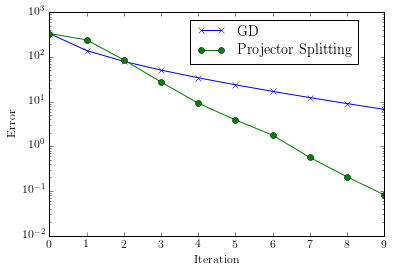

In [11]:
# Case 3: Stair convergence
x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)
eps = 1e-12
u, s, v = x_orig
u1, s1, v1 = x_start
u1 = u1 - u.dot(u.T.dot(u1)) 
v1 = v1 - v.dot(v.T.dot(v1))
x_start = u1, s1, v1
x_orig = diagonalize_core(x_orig)
print 'The singular values of fixed point matrix are \n', s_diag
f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)
grad_dist, proj_dist = [], []
k = 10
# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
# Projector Splitting Convergence
x = x_start
for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    dx_orig = full(x)-full(x_orig)    
    proj_dist.append(la.norm(dx_orig))
    x = projector_splitting_2d(x, dx)
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(proj_dist, marker='o', label="Projector Splitting")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

## Convergence proof

In a recent paper with Denis Kolesnikov we managed to prove the estimates on the convergence.


http://arxiv.org/abs/1604.02111

## Summary 

We do not understand the topology of the manifold (i.e. it behaves almost always like a manifold without singular points!)

## Other open problems

Important problems include solving **non-symmetric systems**, when minimization with residual squares the condition number.

Many applications (include machine learning, recommender systems, ..) are in progress.

## Papers and software
**Software**
- TT-Toolbox: https://github.com/oseledets/ttpy (Python)
- https://github.com/oseledets/TT-Toolbox (MATLAB)

**oseledets.github.io**

In [31]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()